<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/Cropped_and_coloured_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]


['PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif',
 'PaperedControl21v_light.tif']

In [ ]:
train_images=[]
for filename in filenames:
    if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 801


In [ ]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [ ]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

801

In [ ]:

df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20d.tif,marked
1,PaperedControl20d_light.tif,marked
2,PaperedControl21v.tif,marked
3,PaperedControl21v_light.tif,marked
4,PaperedControl21d.tif,marked
...,...,...
796,PaperedControl18d.tif,marked
797,PaperedControl19v.tif,marked
798,PaperedControl19d.tif,marked
799,PaperedControl20v.tif,marked


In [1]:
df.groupby('category').size()

NameError: ignored

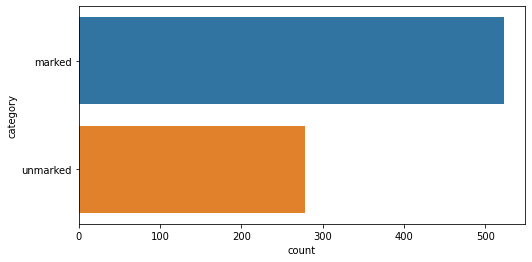

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [159]:
def threscrop(img):
  #convert to grayscale and apply adaptive thresholding
  grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  blur = cv2.GaussianBlur(grayscale,(5,5),0).astype('uint8')
  retval,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  #return thresh

  #detect edges and crop the image
  canny = cv2.Canny(thresh, 50, 200)
  pts = np.argwhere(canny > 0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)
  #cropped_img = img[y1:y2, x1:x2]
  cropped_img = cv2.resize(img[y1:y2, x1:x2], (600,600))


  return cropped_img

In [150]:
def crop(img):

  blurred = cv2.blur(img, (3,3))
  canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

## crop the region
  cropped = img[y1:y2, x1:x2]
  resized=cv2.resize(cropped, (600,600))
  #cv2.imwrite("cropped.png", cropped)
  return resized

  #tagged = cv2.rectangle(img.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
  #cv2.imshow("tagged", tagged)
  #cv2.waitKey()

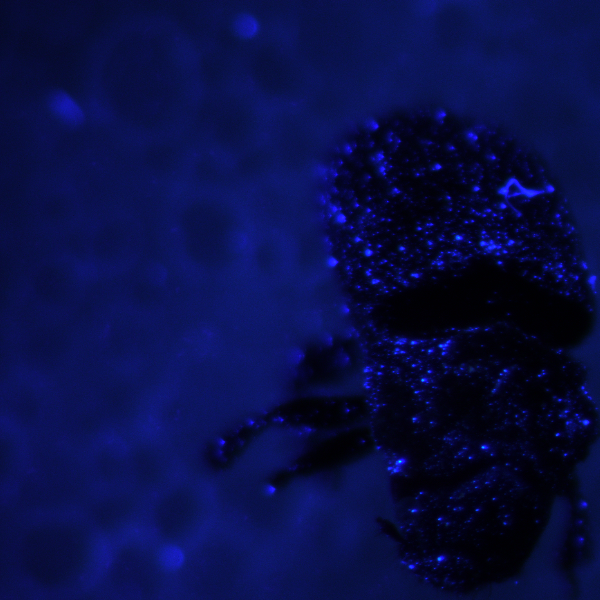

(600, 600, 3)

In [160]:
cv2_imshow(threscrop(image))
threscrop(image).shape

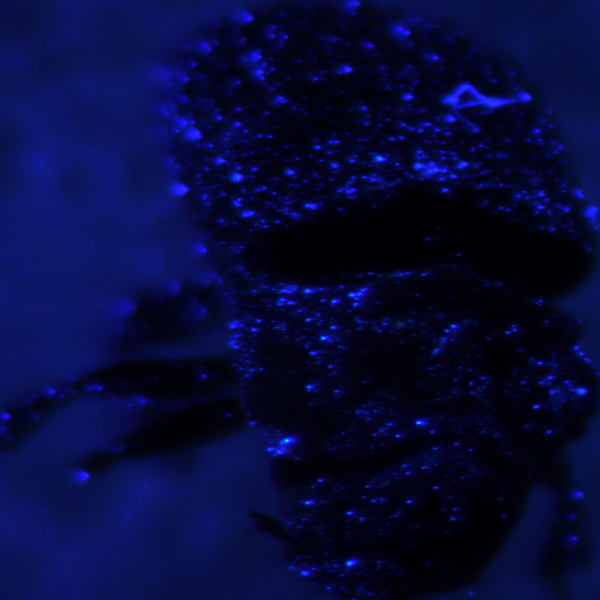

(600, 600, 3)

In [151]:
cv2_imshow(crop(image))
crop(image).shape

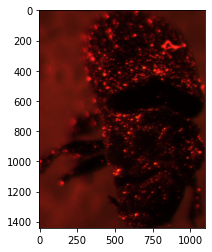

In [ ]:
plt.imshow(crop(image))


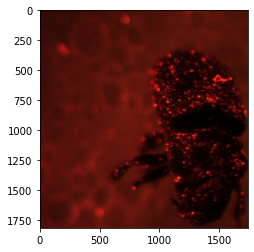

In [ ]:
plt.imshow(threscrop(image))

In [161]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = threscrop(cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id)))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [162]:
tmp_df = df.sample(9)
tmp_df

,filename,category
563,NoPaperedMixed19d.tif,unmarked
305,PaperedTransparent75d.tif,marked
429,NoPaperedGreen24d.tif,unmarked
477,NoPaperedGreen61d.tif,unmarked
466,NoPaperedGreen56v.tif,unmarked
418,NoPaperedGreen28v.tif,unmarked
67,PaperedControl46d.tif,marked
789,PaperedControl15v.tif,marked
794,PaperedControl17d.tif,marked


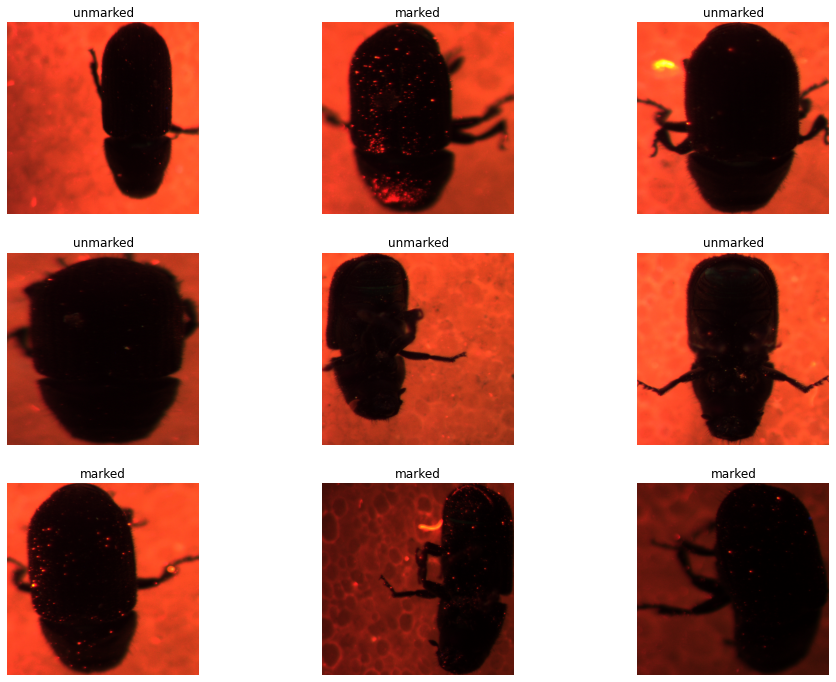

In [163]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [164]:
train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

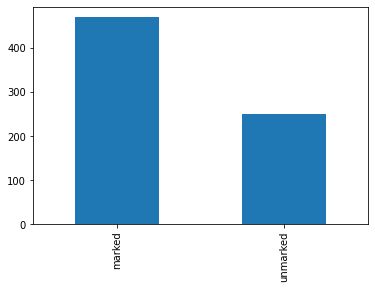

In [165]:
train_df['category'].value_counts().plot.bar()

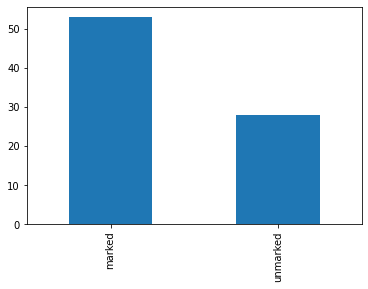

In [166]:
validate_df['category'].value_counts().plot.bar()

In [167]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [168]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = threscrop,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')


In [169]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = threscrop,
                    )

In [170]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 720 validated image filenames belonging to 2 classes.


In [171]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 81 validated image filenames belonging to 2 classes.


In [172]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE))

    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling_13 (Rescaling)        (None, 600, 600, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
normalization_13 (Normalization (None, 600, 600, 3)  7           rescaling_13[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization_13[0][0]           
_______________________________________________________________________________________

In [173]:
EPOCHS = 5
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [174]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [175]:
results = Model_fit()

Epoch 1/5
48/48 [==============================] - 2289s 47s/step - loss: 0.9568 - accuracy: 0.7653 - val_loss: 0.5703 - val_accuracy: 0.6667


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
48/48 [==============================] - 2273s 47s/step - loss: 0.8306 - accuracy: 0.8347 - val_loss: 0.3907 - val_accuracy: 0.8133
Epoch 3/5
48/48 [==============================] - 2312s 48s/step - loss: 0.7365 - accuracy: 0.8375 - val_loss: 0.3539 - val_accuracy: 0.8933
Epoch 4/5
48/48 [==============================] - 2671s 56s/step - loss: 0.5715 - accuracy: 0.8639 - val_loss: 0.2902 - val_accuracy: 0.8800
Epoch 5/5
48/48 [==============================] - 2438s 51s/step - loss: 0.6580 - accuracy: 0.8444 - val_loss: 0.3609 - val_accuracy: 0.8667


In [ ]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.875
Val_Cat-Acc:  0.9200000166893005


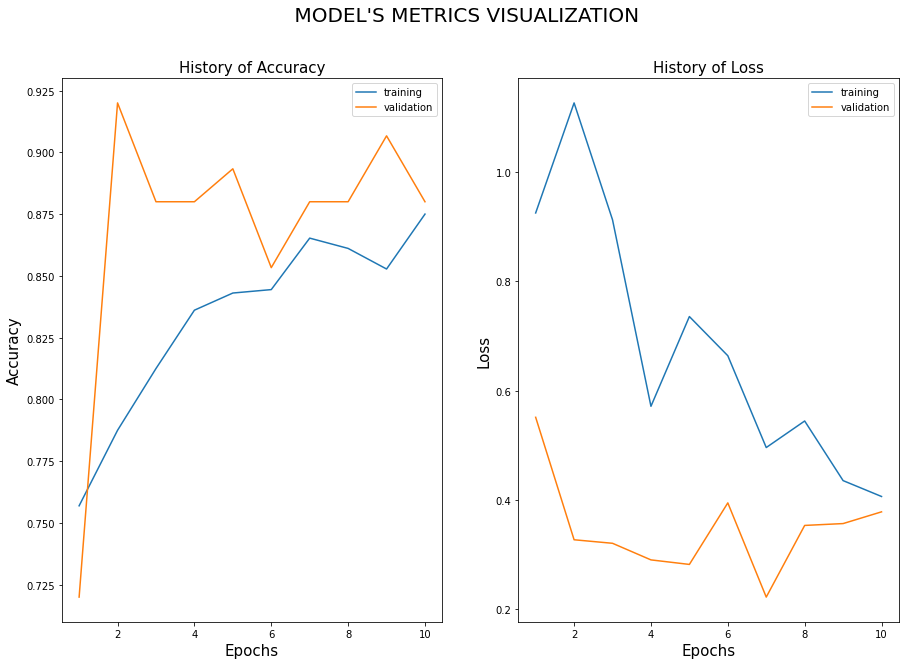

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [ ]:
import keras

final_model = keras.models.load_model('best_model.h5')

In [ ]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
594,NoPaperedMixed35v.tif,unmarked
405,NoPaperedGreen22v.tif,unmarked
655,PaperedMixed15d.tif,marked
34,PaperedControl33d.tif,marked
708,PaperedMixed42d.tif,marked
363,PaperedTransparent104v.tif,marked
516,NoPaperedGreen82v.tif,unmarked
323,PaperedTransparent84v.tif,marked
266,PaperedTransparent57v.tif,marked
478,NoPaperedGreen62v.tif,unmarked


In [ ]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
tmp_df1["prediction"]=preds

In [ ]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
594,NoPaperedMixed35v.tif,unmarked,marked
405,NoPaperedGreen22v.tif,unmarked,unmarked
655,PaperedMixed15d.tif,marked,marked
34,PaperedControl33d.tif,marked,marked
708,PaperedMixed42d.tif,marked,marked
363,PaperedTransparent104v.tif,marked,marked
516,NoPaperedGreen82v.tif,unmarked,unmarked
323,PaperedTransparent84v.tif,marked,marked
266,PaperedTransparent57v.tif,marked,marked
478,NoPaperedGreen62v.tif,unmarked,unmarked
